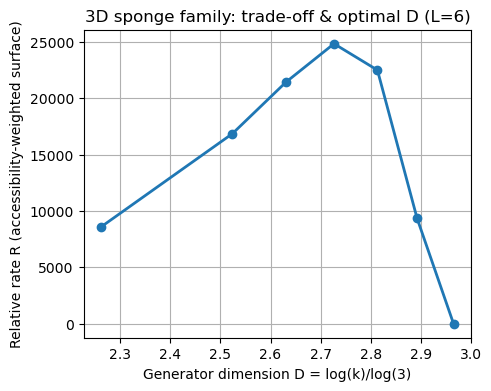

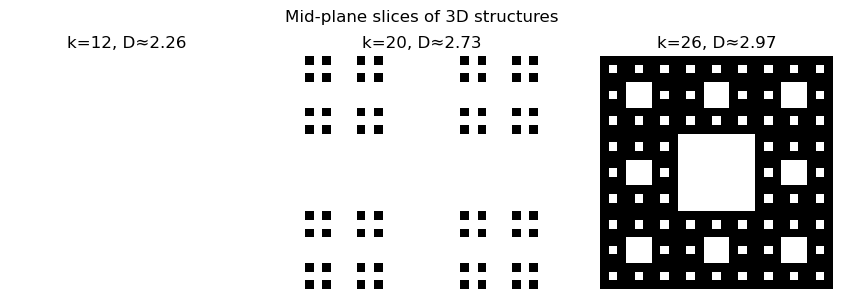

k=12  D≈2.262  R≈8596.7   accessible=10148/13824
k=16  D≈2.524  R≈16844.1   accessible=19248/29404
k=18  D≈2.631  R≈21420.2   accessible=23672/39985
k=20  D≈2.727  R≈24822.5   accessible=27432/49688
k=22  D≈2.814  R≈22482.5   accessible=20156/57706
k=24  D≈2.893  R≈9349.3   accessible=9126/56974
k=26  D≈2.966  R≈0.0   accessible=0/40640


In [1]:
# Lightweight 3D "Menger-like" family + accessibility-weighted rate to reveal an optimal fractal complexity.
# - We generate a parametric 3D sponge (vary number of kept subcubes k in 3x3x3 mask).
# - Theoretical fractal "dimension" proxy: D = log(k)/log(3) for the self-similar generator.
# - For each structure, compute an accessibility-weighted "rate" R(L):
#     R = sum_{surface voxels} 1 / (1 + d/L)
#   where d is the shortest empty-space distance from the outer boundary (BFS on empty voxels).
#   L is a tunable diffusion length (here choose L=6 voxels). 
# - We then scan several k (complexity) values to show a trade-off and an internal optimum.
#
# NOTE: This is a compact demo—not a full physical MC. It matches the intuition in Guo&Keil (2003):
#       more complex -> more surface (benefit) but worse accessibility (cost) -> optimal middle point.

import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def make_generator_mask(k_keep: int):
    """
    Build a 3x3x3 boolean mask with exactly k_keep True subcubes.
    Strategy: rank positions by Manhattan distance from the center (0,0,0),
    keep the ones with *larger* distance first (i.e., remove central cross first),
    so smaller k_keep -> more porous; larger k_keep -> denser.
    """
    coords = []
    for z in range(3):
        for y in range(3):
            for x in range(3):
                dx, dy, dz = x-1, y-1, z-1
                manhattan = abs(dx)+abs(dy)+abs(dz)
                coords.append(((x,y,z), manhattan))
    # sort by distance descending (keep farthest first)
    coords.sort(key=lambda t: (t[1], ), reverse=True)
    mask = np.zeros((3,3,3), dtype=bool)
    for i in range(k_keep):
        (x,y,z), _ = coords[i]
        mask[z,y,x] = True
    return mask

def build_parametric_sponge(level=3, k_keep=20, upscale=2):
    """
    Recursively build a 3^level cube via the 3x3x3 generator with k_keep kept subcubes.
    Then upscale by 'upscale' to get a smoother grid for distance transform.
    """
    gen = make_generator_mask(k_keep)
    # start from a single filled voxel as a 1x1x1 array
    arr = np.ones((1,1,1), dtype=bool)
    for _ in range(level):
        # Kronecker product with generator
        arr = np.kron(arr, gen)
    if upscale>1:
        arr = np.kron(arr, np.ones((upscale,upscale,upscale), dtype=bool))
    return arr  # True = solid

def surface_mask(sol):
    """Return boolean mask of surface voxels: solid cells adjacent to at least one empty cell."""
    Z,Y,X = sol.shape
    surf = np.zeros_like(sol, dtype=bool)
    # pad to simplify neigh checks
    pad = np.pad(sol, 1, mode='constant', constant_values=False)
    # neighbor differences
    for dz,dy,dx in [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]:
        neigh = pad[1+dz:1+dz+Z, 1+dy:1+dy+Y, 1+dx:1+dx+X]
        # solid with an empty neighbor in this direction contributes to surface
        surf |= (sol & (~neigh))
    return surf

def empty_distance_transform(sol):
    """
    BFS distance transform on EMPTY voxels from the *outer boundary*.
    Returns d[y,x,z] = shortest steps through empty space from boundary;
    solid voxels carry a large sentinel value.
    """
    Z,Y,X = sol.shape
    INF = 10**9
    d = np.full((Z,Y,X), INF, dtype=np.int32)
    q = deque()
    # initialize with boundary empty cells
    def push_if_empty(x,y,z):
        if not sol[z,y,x] and d[z,y,x]==INF:
            d[z,y,x]=0
            q.append((x,y,z))
    for z in range(Z):
        for y in range(Y):
            for x in [0, X-1]:
                push_if_empty(x,y,z)
    for z in range(Z):
        for x in range(X):
            for y in [0, Y-1]:
                push_if_empty(x,y,z)
    for y in range(Y):
        for x in range(X):
            for z in [0, Z-1]:
                push_if_empty(x,y,z)
    # BFS in empty region
    moves = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
    while q:
        x,y,z = q.popleft()
        dd = d[z,y,x]
        for dx,dy,dz in moves:
            xn,yn,zn = x+dx, y+dy, z+dz
            if 0<=xn<X and 0<=yn<Y and 0<=zn<Z:
                if (not sol[zn,yn,xn]) and d[zn,yn,xn] > dd+1:
                    d[zn,yn,xn] = dd+1
                    q.append((xn,yn,zn))
    return d

def effective_rate(sol, L=6):
    """
    Accessibility-weighted relative rate on surface:
      R = sum_{surface voxels} 1 / (1 + d/L)
    where d is minimum empty-space distance of neighboring empty voxel (closest approach).
    """
    Z,Y,X = sol.shape
    d_empty = empty_distance_transform(sol)
    surf = surface_mask(sol)
    zs, ys, xs = np.where(surf)
    if len(xs)==0:
        return 0.0, 0, 0
    # for each surface voxel, find the minimum distance of its empty neighbors
    w_sum = 0.0
    accessible = 0
    moves = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
    for z,y,x in zip(zs,ys,xs):
        dmin = 10**9
        for dx,dy,dz in moves:
            xn,yn,zn = x+dx, y+dy, z+dz
            if 0<=xn<X and 0<=yn<Y and 0<=zn<Z:
                if d_empty[zn,yn,xn] < dmin:
                    dmin = d_empty[zn,yn,xn]
        # weight
        w = 1.0/(1.0 + dmin/float(L))
        w_sum += w
        if dmin <= L:
            accessible += 1
    return w_sum, accessible, len(xs)

# ---- Scan multiple generator complexities (k_keep) ----
k_values = [12, 16, 18, 20, 22, 24, 26]  # 12~26 kept per 3x3x3 cell
level = 3       # recursion depth -> base resolution 27; upscaled later
upscale = 2     # total grid ~ (27*2)^3 = 54^3 ~ 157k voxels
L = 6           # diffusion length (voxels)

Ds = []         # theoretical fractal dimension proxy: log(k)/log(3)
Rs = []         # relative rate
Accs = []       # accessible surface count
SurfN = []      # total surface voxels

for k in k_values:
    sol = build_parametric_sponge(level=level, k_keep=k, upscale=upscale)  # True = solid
    R, acc, sn = effective_rate(sol, L=L)
    Ds.append(np.log(k)/np.log(3))
    Rs.append(R)
    Accs.append(acc)
    SurfN.append(sn)

# ---- Plots ----
plt.figure(figsize=(5,4))
plt.plot(Ds, Rs, "o-", linewidth=2)
plt.xlabel("Generator dimension D = log(k)/log(3)")
plt.ylabel("Relative rate R (accessibility-weighted surface)")
plt.title(f"3D sponge family: trade-off & optimal D (L={L})")
plt.grid(True)
plt.show()

# Show a couple of cross-sections for visual intuition (min, mid, max D)
fig, axes = plt.subplots(1,3, figsize=(9,3))
sample_idxs = [0, len(k_values)//2, -1]
for ax, idx in zip(axes, sample_idxs):
    k = k_values[idx]
    sol = build_parametric_sponge(level=level, k_keep=k, upscale=upscale)
    midz = sol.shape[0]//2
    ax.imshow(sol[midz], cmap="gray_r", origin="lower")
    ax.set_title(f"k={k}, D≈{np.log(k)/np.log(3):.2f}")
    ax.axis("off")
plt.suptitle("Mid-plane slices of 3D structures")
plt.tight_layout()
plt.show()

# Print numeric summary
for k, D, R, acc, sn in zip(k_values, Ds, Rs, Accs, SurfN):
    print(f"k={k:2d}  D≈{D:.3f}  R≈{R:.1f}   accessible={acc}/{sn}")
